In [1]:
#ifif using colab
# ! pip install hmmlearn
# ! pip install yfinance

# Packages and Data Split

In [2]:
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import numpy as np
from hmmlearn import hmm
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

In [3]:
# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 

In [22]:
aapl = yf.download("GOOGL", start="2018-01-01", end="2021-12-31").reset_index()
aapl.Date = pd.to_datetime(aapl.Date)

[*********************100%***********************]  1 of 1 completed


In [23]:
aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1053.020020,1075.979980,1053.020020,1073.209961,1073.209961,1588268
1,2018-01-03,1073.930054,1096.099976,1073.430054,1091.520020,1091.520020,1565945
2,2018-01-04,1097.089966,1104.076538,1094.260010,1095.760010,1095.760010,1302569
3,2018-01-05,1103.449951,1113.579956,1101.795044,1110.290039,1110.290039,1512526
4,2018-01-08,1111.000000,1119.160034,1110.000000,1114.209961,1114.209961,1232221
...,...,...,...,...,...,...,...
989,2021-12-06,2860.810059,2877.050049,2803.000000,2863.100098,2863.100098,1530905
990,2021-12-07,2911.929932,2950.623291,2904.550049,2945.389893,2945.389893,1612015
991,2021-12-08,2951.929932,2967.860107,2928.120117,2963.729980,2963.729980,1182594
992,2021-12-09,2951.820068,2982.000000,2942.300049,2952.770020,2952.770020,1139828


In [41]:
daily_return = aapl['Return'] = np.log(aapl.Close /aapl.Close.shift(-1)).dropna()
#(np.log(aapl.Close /aapl.Close.shift(-1))).dropna()
# np.log(aapl.Close.pct_change()).dropna()

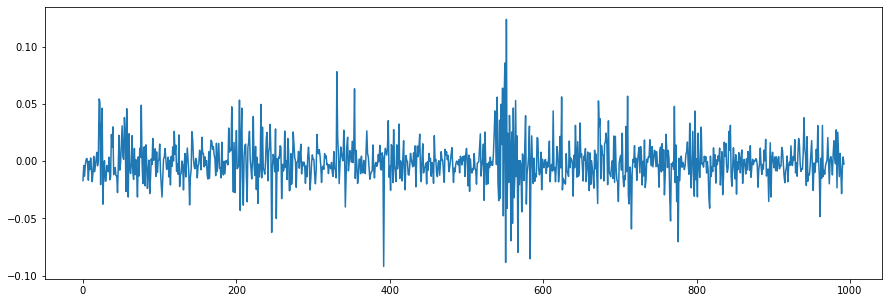

In [42]:
plt.plot(daily_return)

In [43]:
aapl[aapl.Date>='2021-01-01']

,Date,Open,High,Low,Close,Adj Close,Volume,Return
756,2021-01-04,1760.000000,1762.489868,1707.140015,1726.130005,1726.130005,1866195,-0.008032
757,2021-01-05,1725.089966,1746.829956,1716.900024,1740.050049,1740.050049,1017962,0.009917
758,2021-01-06,1700.255005,1743.964966,1696.101440,1722.880005,1722.880005,2329401,-0.029431
759,2021-01-07,1726.760010,1777.819946,1726.760010,1774.339966,1774.339966,2096829,-0.013152
760,2021-01-08,1777.160034,1799.354980,1761.219971,1797.829956,1797.829956,1774226,0.023377
...,...,...,...,...,...,...,...,...
989,2021-12-06,2860.810059,2877.050049,2803.000000,2863.100098,2863.100098,1530905,-0.028336
990,2021-12-07,2911.929932,2950.623291,2904.550049,2945.389893,2945.389893,1612015,-0.006207
991,2021-12-08,2951.929932,2967.860107,2928.120117,2963.729980,2963.729980,1182594,0.003705
992,2021-12-09,2951.820068,2982.000000,2942.300049,2952.770020,2952.770020,1139828,-0.002456


In [45]:
train,test = aapl[aapl.Date<'2021-01-01'].Return,aapl[aapl.Date>='2021-01-01'].Return
# train,test = daily_return[:2800],daily_return[-238:]

In [47]:
train_np = np.array(train).reshape(-1,1)
test_np = np.array(test[:-1]).reshape(-1,1)

# HMM 

In [48]:
def hmm_prediction(train_data,num_of_predictions):
    hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
    hmm_model.fit(train_data)
    
    predict_state = hmm_model.predict(train_data)
    
    hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
    hmm_prediction_value = hmm_prediction[0]
    hmm_prediction_states = hmm_prediction[1]
    
    return hmm_prediction_value

In [49]:
#hmm_prediction(train_np,238)

In [50]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
remodel.fit(train_np)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000)

In [51]:
plot_data = train_np
predict_state = remodel.predict(plot_data)

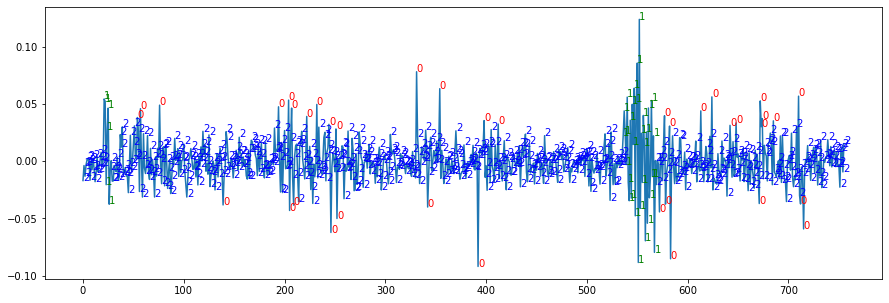

In [52]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(plot_data)
color_set = ['r','g','b']
for i, txt in enumerate(predict_state):
    plt.annotate(int(txt), (i, plot_data[i]),c=color_set[int(txt)])

In [53]:
hmm_prediction = remodel.sample(len(test_np),random_state = predict_state[-1])
hmm_prediction_value = hmm_prediction[0]
hmm_prediction_states = hmm_prediction[1]

In [54]:
len(hmm_prediction_value)

237

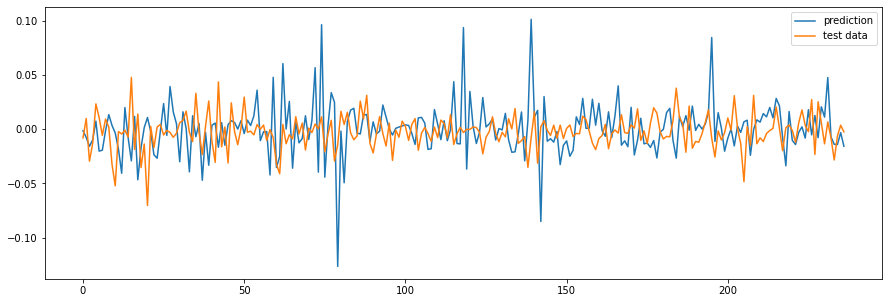

In [55]:
plt.plot(hmm_prediction_value,label = 'prediction')
plt.plot(test_np, label = 'test data')
plt.legend()

In [59]:
save_to_csv_predictino = pd.DataFrame(hmm_prediction_value)
save_to_csv_predictino.columns = ['HMM']


In [18]:
def reject_outliers(data, m=1.5):
    ceiling = np.mean(data)+ m * np.std(data)
    floor = np.mean(data)- m * np.std(data)
    
    return np.clip(data,a_min = floor, a_max = ceiling)

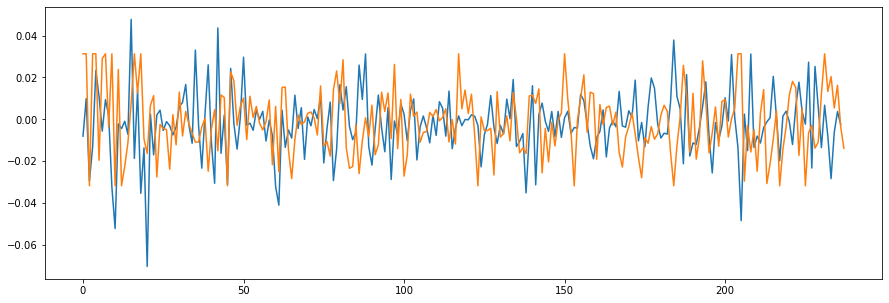

In [19]:
clipped_test = reject_outliers(test_np)
clipped_prediction = reject_outliers(hmm_prediction_value)
plt.plot(clipped_test)
plt.plot(clipped_prediction)

In [20]:
mean_absolute_percentage_error(clipped_prediction,clipped_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
len(test_np)

In [ ]:
mean_absolute_percentage_error(hmm_prediction_value,test_np)

In [ ]:
mean_squared_error(test_np,hmm_prediction_value)

In [ ]:
sm.tsa.stattools.ccf(test_np, hmm_prediction_value)

In [ ]:
plt.plot(test_np,hmm_prediction_value)

In [ ]:
plt.scatter(test_np,hmm_prediction_value)